# Fig. 17: Injected chem. eq. abundance S/N maps

In [7]:
import pickle
from matplotlib import pyplot as plt
import os
from astropy import units as u
import sys
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [8]:
def get_planet_params(data, trial_kp, trial_vsys):
    yy, xx = np.meshgrid(trial_kp, trial_vsys)
    indmax = np.unravel_index(data.argmax(), data.shape)
    vsys_max, kp_max = xx[indmax], yy[indmax]
    value_max = data[indmax]
    return vsys_max, kp_max, value_max

In [9]:
vsys = -20.82e3 * (u.m/u.s) # Yan+23
kp = 197e3 * (u.m/u.s) # Anderson+18
LABELSIZE=11

In [10]:
APJ_SINGLE_COL = 3.5
APJ_DOUBLE_COL = 7.
TEXTSIZE=12
TEXTSIZE=12

In [11]:
def plot_detection_matrix(data, dkp_all, dvsys_all, kp, vsys, mode='snr', title='', interp_method='bicubic', ax='None', **kwargs):
    """Plot Kp-vsys map."""
    extend='neither'
    quantity = r'S/N'
    cmap = kwargs.pop('cmap', 'Reds_r')
    markercolor = 'w'
    snr_min = kwargs.pop('snr_min', np.nanmin(data))
    snr_max = kwargs.pop('snr_max', np.ceil(10*np.nanmax(data))/10.)

    snr_step = kwargs.pop('snr_step', 0.25)
    ncolors = int(1+(snr_max - snr_min)/snr_step)
    if ncolors > 256:
        ncolors = 256

    cmap = mpl.colormaps[cmap]
    cmap.set_bad('gray',1.)
    bounds = np.round(np.linspace(snr_min, snr_max, ncolors), 1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    # Set appropriate ranges
    dvsys = dvsys_all[1]-dvsys_all[0]
    dkp = dkp_all[1]-dkp_all[0]
    global extent
    extent=[
        (dvsys_all[0]-dvsys/2.)/1e3,
        (dvsys_all[-1]+dvsys/2.)/1e3,
        (dkp_all[0]-dkp/2.+kp)/1e3,
        (dkp_all[-1]+dkp/2.+kp)/1e3
    ]

    # Plot matrix
    im = ax.imshow(data.T, origin='lower',
                   extent=extent,
                   aspect='auto', cmap=cmap,
                   norm=norm, interpolation=interp_method)
    ax.tick_params(labelsize=TEXTSIZE)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.0)

    #ax.set_xlabel(r'System velocity (km/s)', size=TEXTSIZE)
    #ax.set_ylabel(r'$\rm{K}_{\rm{p}}$ (km/s)', size=TEXTSIZE)

    # Plot dotted lines to the planet's estimate (vsys, kp)
    bads = np.isnan(data)
    data_masked = np.copy(data)
    data_masked[bads] = 0.
    vsys_max, kp_max, value_max = get_planet_params(data_masked, kp+dkp_all, dvsys_all) # find min instead of max in this mode

    ax.plot([vsys/1e3, vsys/1e3], [extent[2], (kp-15e3)/1e3], ls='--', color='w', lw=2, label='expected')
    ax.plot([vsys/1e3, vsys/1e3], [(kp+15e3)/1e3, extent[3]-25], ls='--', color='w', lw=2)
    ax.plot([extent[0], (vsys-10e3)/1e3], [kp/1e3, kp/1e3], ls='--', color='w', lw=2)
    ax.plot([(vsys+10e3)/1e3, extent[1]], [kp/1e3, kp/1e3], ls='--', color='w', lw=2)
    ax.scatter( (vsys_max)/1e3, (kp_max)/1e3, marker="8", s=20, facecolors='w', edgecolors='k', linewidths=0.5, label='maximum SNR')
    
    # Add text with highest SNR
    ax.annotate('{} = {:.1f}\n'.format(quantity, value_max),
                (0.5, 0.975), xycoords='axes fraction', ha='center', va='top', size=TEXTSIZE, color='w', fontweight='bold')

    # Plot colorbar
    cbar = plt.colorbar(mappable=im, cax=cax,extend=extend)
    #cbar.set_label('{}'.format(quantity), size=TEXTSIZE)
    cax.tick_params(labelsize=TEXTSIZE-2)

    # Set title
    #leg = ax.legend(fontsize=TEXTSIZE, frameon=False)
    #plt.setp(leg.get_texts(), color='w')
    ax.set_xlim(dvsys_all[0]/1e3, dvsys_all[-1]/1e3)
    ax.set_ylim(kp/1e3+dkp_all[0]/1e3, kp/1e3+dkp_all[-1]/1e3)
    return ax, cax, cbar

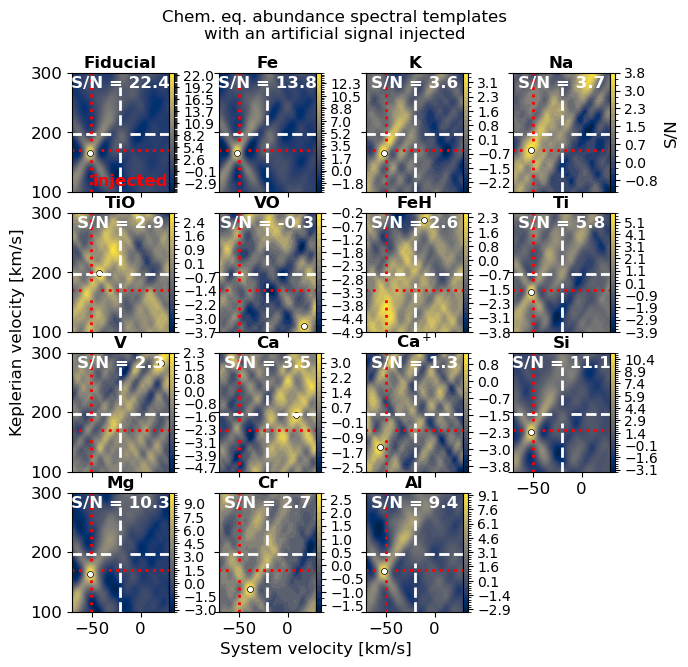

In [12]:
import matplotlib.gridspec as gridspec
from astropy.stats import sigma_clip

species = [
    'all',
    'Fe',
    '39K__Allard',
    '23Na__Allard',
    'Ti-O-NatAbund__Toto',
    '51V-16O__HyVO',
    'FeH',
    'Ti',
    'V',
    'Ca',
    'Ca_p',
    'Si',
    'Mg',
    'Cr',
    'Al',
]

species_label = [
    'Fiducial',
    'Fe',
    'K',
    'Na',
    'TiO',
    'VO',
    'FeH',
    'Ti',
    'V',
    'Ca',
    r'Ca$^+$',
    'Si',
    'Mg',
    'Cr',
    'Al',
]


#species = ['Fe_p', 'Mg', 'Si', 'Ti', 'V', 'V_p', 'Al', 'B', 'Be', 'Ca', 'Cr',]

obs_id= 'WASP-189_2023A_2023_06_09_2024A_2024_04_19'
# obs_id_list = [
#     'WASP-189_2024A_2024_04_20'
# ]
ncols = int(np.ceil(np.sqrt(float(len(species)))))
nrows = int(np.ceil(np.sqrt(float(len(species)))))

dirin_xcor = '../data/xcor_out'
template = 'chem_eq'
scaling = 1 # 0.38
#dr_id = 'NPC_7_mp_70_ccw'
dr_id = 'NPC_7_mp_70_sf_1.000_dvsys_inj_-30_dkp_inj_-30_ccw'
ns = -1

ncols = 4
nrows = 4
fig = plt.figure(figsize=(APJ_DOUBLE_COL, APJ_DOUBLE_COL))
spec2 = gridspec.GridSpec(ncols=nrows, nrows=ncols, wspace=0.45, hspace=0.175, figure=fig)

for i in range(ncols):
    for j in range(nrows):
        ns += 1
        if ns > len(species) -1:
            break

        dirin = f'{dirin_xcor}/{obs_id}/W189b_pRT_1D_Yan22_{template}_{species[ns]}/{dr_id}'
        trial_kp, trial_vsys, signalmap = pickle.load(open(os.path.join(dirin, 'snrmap.pkl'), 'rb'))
        snrmatrix = signalmap * scaling # / np.std(sigma_clip(signalmap, 2))

        ax1 = fig.add_subplot(spec2[i, j])

        ax1, cax1, cbar1 = plot_detection_matrix(
            data=snrmatrix,
            dkp_all=trial_kp-kp.to(u.m/u.s).value,
            dvsys_all=trial_vsys+vsys.to(u.m/u.s).value,
            kp=kp.to(u.m/u.s).value,
            vsys=vsys.to(u.m/u.s).value,
            cmap='cividis',
            ax=ax1
        )    

        if (i <= 2 and not (i==2 and j==3)):
            ax1.set_xticklabels([])
        if j > 0:
            ax1.set_yticklabels([])
        if (i == 1 and j==0):
            ax1.set_ylabel(r'Keplerian velocity [km/s]', size=TEXTSIZE, y=-0.)
        if (i == 0 and j==3):
            cbar1.set_label(r'S/N', size=TEXTSIZE)
        if (i == 3 and j==1):
            ax1.set_xlabel(r'System velocity [km/s]', size=TEXTSIZE, x=1)

        ax1.set_title(f'{species_label[ns]}', fontsize=TEXTSIZE, fontweight='bold', y=0.97)
        ax1.tick_params('both', labelsize=TEXTSIZE)
        
        c_inj = 'red'
        vsys_inj = vsys.to(u.m/u.s).value - 30e3
        offset = 200.7e3 - 197e3 # used different kp for analysis, but can correct here!
        kp_inj = kp.to(u.m/u.s).value -30e3 + offset
        ax1.plot([vsys_inj/1e3, vsys_inj/1e3], [extent[2], (kp_inj-15e3)/1e3], ls=':', color=c_inj, lw=2, label='expected')
        ax1.plot([vsys_inj/1e3, vsys_inj/1e3], [(kp_inj+15e3)/1e3, extent[3]], ls=':', color=c_inj, lw=2)
        ax1.plot([extent[0], (vsys_inj-10e3)/1e3], [kp_inj/1e3, kp_inj/1e3], ls=':', color=c_inj, lw=2)
        ax1.plot([(vsys_inj+10e3)/1e3, extent[1]], [kp_inj/1e3, kp_inj/1e3], ls=':', color=c_inj, lw=2)
        if (i==0 and j==0):
            ax1.annotate('injected', xy=(-50, 110), size=TEXTSIZE, color=c_inj, fontweight='bold')
        
plt.suptitle('Chem. eq. abundance spectral templates\nwith an artificial signal injected', size=TEXTSIZE, y=0.97)

plt.savefig(f'../figures/Fig17_snrmaps_all_inj_chem_eq.pdf', bbox_inches='tight')
plt.savefig(f'../figures/Fig17_snrmaps_all_inj_chem_eq.png', dpi=200, bbox_inches='tight')
plt.show()